# HIGGS dataset — sampling, split and EDA

This notebook samples 500,000 rows from the full `data/HIGGS.csv` (approx 11M rows), performs an 80/10/10 split (train/val/test), and includes exploratory data analysis (class balance, basic stats, and plots). The sampling uses reservoir sampling to avoid loading the entire file into memory. Saved splits will be written to `data/samples` as parquet files for efficient later training.

In [10]:
# Imports and configuration
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

DATA_PATH = os.path.join('..', 'data', 'HIGGS.csv')
SAMPLE_SIZE = 500_000
CHUNK_SIZE = 100_000
RANDOM_STATE = 42
OUT_DIR = os.path.join('..', 'data', 'samples')
os.makedirs(OUT_DIR, exist_ok=True)
print('Config: DATA_PATH=', DATA_PATH)

Config: DATA_PATH= ../data/HIGGS.csv


In [4]:
def reservoir_sample_csv(path, sample_size, chunksize=100_000, random_state=42):
    rng = np.random.default_rng(random_state)
    reservoir = []
    total = 0
    # We assume the CSV has no header (HIGGS usually does not). Adjust header=None/header=0 if needed.
    for chunk in pd.read_csv(path, header=None, chunksize=chunksize):
        arr = chunk.values
        for row in arr:
            total += 1
            if len(reservoir) < sample_size:
                reservoir.append(row)
            else:
                # random integer in [0, total)
                j = rng.integers(0, total)
                if j < sample_size:
                    reservoir[j] = row
    df = pd.DataFrame(reservoir)
    return df

# Run sampling (this may take several minutes depending on disk speed)
sample_df = reservoir_sample_csv(DATA_PATH, SAMPLE_SIZE, CHUNK_SIZE, RANDOM_STATE)
print('Sampled dataframe shape:', sample_df.shape)

Sampled dataframe shape: (500000, 29)


In [ ]:
# Name columns: first column is label, the rest are features.
n_cols = sample_df.shape[1]
col_names = ['label'] + [f'f{i}' for i in range(1, n_cols)]
sample_df.columns = col_names
# quick check
print('Columns ->', sample_df.columns[:6].tolist(), '... total columns =', n_cols)
print(sample_df.head())

Columns -> ['label', 'f1', 'f2', 'f3', 'f4', 'f5'] ... total columns = 29
   label        f1        f2        f3        f4        f5        f6  \
0    0.0  0.969033  0.247334 -1.157684  0.599414  0.340823  0.411958   
1    1.0  1.515132 -0.603915 -0.183900  0.994922  0.127168  0.373483   
2    0.0  0.986602 -1.903189  1.388125  0.950116  0.592708  0.504573   
3    0.0  1.504518  0.475243 -0.153383  0.806322 -0.133105  1.042857   
4    0.0  0.496321 -0.029273 -1.407927  1.953362 -0.338721  0.623845   

         f7        f8        f9  ...       f19       f20       f21       f22  \
0  2.532983  0.549547  0.000000  ...  2.069938 -1.591755  0.000000  0.796719   
1 -2.641959 -1.390872  0.000000  ...  0.186925 -1.300981  0.000000  0.909460   
2 -0.370371 -0.536577  0.000000  ... -0.598428 -0.875918  3.101961  1.269457   
3  0.586191  1.661624  2.173076  ...  0.132791 -0.684473  0.000000  0.831861   
4 -0.169355  1.448744  1.086538  ...  0.342662 -0.833190  0.000000  1.034940   

        f23 

In [6]:
# Shuffle and split 80/10/10 with stratification on the label
sample_df = sample_df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)
train_val, test = train_test_split(sample_df, test_size=0.1, random_state=RANDOM_STATE, stratify=sample_df['label'])
train, val = train_test_split(train_val, test_size=(0.1/0.9), random_state=RANDOM_STATE, stratify=train_val['label'])
print('Train shape:', train.shape)
print('Validation shape:', val.shape)
print('Test shape:', test.shape)

Train shape: (400000, 29)
Validation shape: (50000, 29)
Test shape: (50000, 29)


In [12]:
# Save each split as a separate CSV file and confirm
train_csv = os.path.join(OUT_DIR, 'higgs_train.csv')
val_csv = os.path.join(OUT_DIR, 'higgs_val.csv')
test_csv = os.path.join(OUT_DIR, 'higgs_test.csv')

print('Saving CSVs (this may take a moment)')
train.to_csv(train_csv, index=False)
val.to_csv(val_csv, index=False)
test.to_csv(test_csv, index=False)
print('Saved:')
print('-', train_csv)
print('-', val_csv)
print('-', test_csv)

# Quick confirmation: check files exist, print sizes, show label balance and head of train
import os
for p in [train_csv, val_csv, test_csv]:
    exists = os.path.exists(p)
    size = os.path.getsize(p) if exists else None
    print(f'{p} -> exists={exists}, size={size}')

print('\nLabel balance (counts and percentages) from in-memory splits:')
for name, df in [('train', train), ('val', val), ('test', test)]:
    counts = df['label'].value_counts().sort_index()
    pct = df['label'].value_counts(normalize=True).sort_index() * 100
    print(f'== {name.upper()} ==')
    print('counts:', counts.to_dict())
    print('pct (%):', pct.round(4).to_dict())

print('\nTrain head (first 5 rows):')
print(train.head().to_string(index=False, max_rows=5))

Saving CSVs (this may take a moment)
Saved:
- ../data/samples/higgs_train.csv
- ../data/samples/higgs_val.csv
- ../data/samples/higgs_test.csv
../data/samples/higgs_train.csv -> exists=True, size=202512430
../data/samples/higgs_val.csv -> exists=True, size=25315873
../data/samples/higgs_test.csv -> exists=True, size=25313766

Label balance (counts and percentages) from in-memory splits:
== TRAIN ==
counts: {0.0: 188484, 1.0: 211516}
pct (%): {0.0: 47.121, 1.0: 52.879}
== VAL ==
counts: {0.0: 23560, 1.0: 26440}
pct (%): {0.0: 47.12, 1.0: 52.88}
== TEST ==
counts: {0.0: 23561, 1.0: 26439}
pct (%): {0.0: 47.122, 1.0: 52.878}

Train head (first 5 rows):
 label       f1        f2        f3       f4        f5       f6        f7        f8       f9      f10       f11       f12      f13      f14       f15       f16      f17      f18       f19       f20      f21      f22      f23      f24      f25      f26      f27      f28
   1.0 0.719958  0.785939  0.981966 0.553060  1.383569 0.925050  1.85368

Rows: train=400000, val=50000, test=50000

Dtype counts (train):
float64    29
Name: count, dtype: int64

Top 10 columns by missing values (train):


,train_na,val_na,test_na,train_na_pct,val_na_pct,test_na_pct
label,0,0,0,0.0,0.0,0.0
f15,0,0,0,0.0,0.0,0.0
f27,0,0,0,0.0,0.0,0.0
f26,0,0,0,0.0,0.0,0.0
f25,0,0,0,0.0,0.0,0.0
f24,0,0,0,0.0,0.0,0.0
f23,0,0,0,0.0,0.0,0.0
f22,0,0,0,0.0,0.0,0.0
f21,0,0,0,0.0,0.0,0.0
f20,0,0,0,0.0,0.0,0.0



Columns with a single unique value (constant):
[]

Columns with infinite values: []

Number of features = 28


,count,mean,std,min,25%,50%,75%,max
f1,400000.0,0.990209,0.563875,0.274697,0.589655,0.852639,1.234396,8.673899
f2,400000.0,-0.002442,1.009147,-2.434976,-0.742218,-0.002976,0.736266,2.434868
f3,400000.0,-0.002988,1.006801,-1.742508,-0.877479,-0.004125,0.868220,1.743236
f4,400000.0,0.999248,0.599232,0.002615,0.576980,0.891949,1.294053,9.554140
f5,400000.0,0.004009,1.006507,-1.743932,-0.866074,0.006585,0.876377,1.743257
f6,400000.0,0.990241,0.474604,0.138602,0.678993,0.894361,1.169091,8.577184
f7,400000.0,0.001014,1.008675,-2.969725,-0.688235,0.000965,0.689175,2.969674
f8,400000.0,0.003226,1.006325,-1.741237,-0.864770,0.004596,0.871085,1.741454
f9,400000.0,0.998825,1.027567,0.000000,0.000000,1.086538,2.173076,2.173076
f10,400000.0,0.992343,0.499935,0.188981,0.656587,0.889634,1.201497,8.550611



Top 10 features by absolute skew (train):


f22    6.393317
f23    4.985976
f24    4.615907
f25    2.785867
f27    2.682591
f28    2.533592
f26    2.442628
f10    1.976547
f6     1.916000
f1     1.747882
Name: skew, dtype: float64


Top features correlated with label (abs):


f26    0.150248
f28    0.123469
f4     0.102938
f27    0.066599
f6     0.057032
f1     0.049158
f13    0.048797
f18    0.035576
f25    0.031256
f23    0.025188
f17    0.024235
f10    0.024021
f14    0.014441
f22    0.013541
f21    0.012836
f24    0.012166
f9     0.009622
f12    0.002620
f15    0.002551
f3     0.002397
Name: label, dtype: float64


Number of feature pairs with correlation >= 0.95: 0

Computing VIF (this may take a moment)


f27    75.475361
f28    62.546349
f23    32.621635
f24    24.683500
f25    13.724058
f22     9.561209
f26     9.423330
f6      8.663242
f10     7.802759
f14     6.866194
f18     5.764555
f1      5.180563
f4      5.179284
f9      3.505008
f13     3.094366
f17     2.591914
f21     2.230252
f8      1.196188
f2      1.166021
f7      1.158436
dtype: float64


Feature value percentiles (first 10 features):


,0.00,0.01,0.10,0.50,0.90,0.99,1.00
f1,0.274697,0.295743,0.430254,0.852639,1.737305,2.892825,8.673899
f2,-2.434976,-2.128176,-1.354845,-0.002976,1.352789,2.127094,2.434868
f3,-1.742508,-1.708662,-1.394610,-0.004125,1.392564,1.708280,1.743236
f4,0.002615,0.111828,0.354885,0.891949,1.763717,2.945213,9.554140
f5,-1.743932,-1.708984,-1.393141,0.006585,1.395047,1.709424,1.743257
f6,0.138602,0.331710,0.523444,0.894361,1.545597,2.768555,8.577184
f7,-2.969725,-2.436981,-1.254647,0.000965,1.260537,2.442872,2.969674
f8,-1.741237,-1.704094,-1.395862,0.004596,1.399404,1.704865,1.741454
f9,0.000000,0.000000,0.000000,1.086538,2.173076,2.173076,2.173076
f10,0.188981,0.303679,0.497067,0.889634,1.585755,2.795817,8.550611


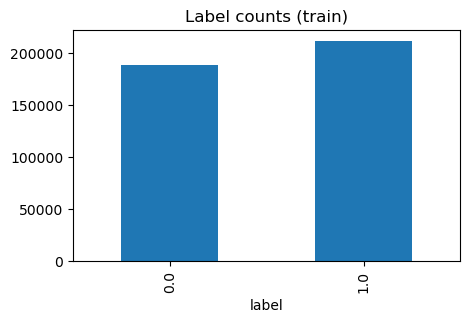

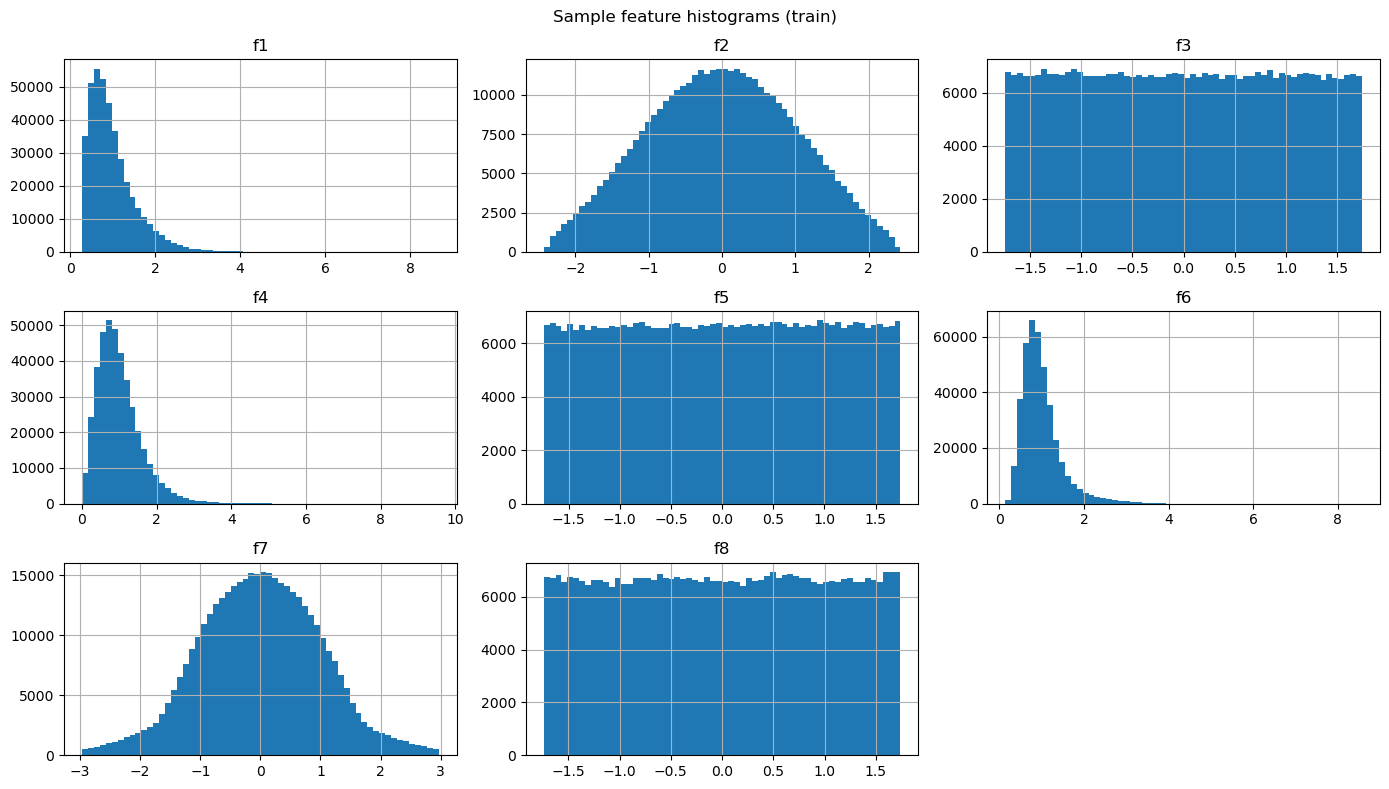


EDA complete. Review outputs above for missingness, skew, scale, and collinearity.


In [ ]:
# Exploratory analysis to guide preprocessing
pd.options.display.max_columns = 60

print('Rows: train={}, val={}, test={}'.format(len(train), len(val), len(test)))

# 1) dtypes and basic counts
print('\nDtype counts (train):')
print(train.dtypes.value_counts())

# 2) Missing values (absolute and percent) across splits
na_df = pd.DataFrame({
    'train_na': train.isna().sum(),
    'val_na': val.isna().sum(),
    'test_na': test.isna().sum(),
})
na_df['train_na_pct'] = na_df['train_na'] / len(train) * 100
na_df['val_na_pct'] = na_df['val_na'] / len(val) * 100
na_df['test_na_pct'] = na_df['test_na'] / len(test) * 100

print('\nTop 10 columns by missing values (train):')
display(na_df.sort_values('train_na', ascending=False).head(10))

# 3) Unique counts and constant cols
uniq = train.nunique()
print('\nColumns with a single unique value (constant):')
const_cols = uniq[uniq <= 1].index.tolist()
print(const_cols)

# 4) Check for infinite values
inf_cols = [c for c in train.columns if np.isinf(train[c]).any()]
print('\nColumns with infinite values:', inf_cols)

# 5) Descriptive stats for numeric features
feature_cols = [c for c in train.columns if c != 'label']
print('\nNumber of features =', len(feature_cols))
desc = train[feature_cols].describe().T
display(desc.head(10))

# 6) Skewness and kurtosis (look for strongly skewed features)
skew = train[feature_cols].skew()
kurt = train[feature_cols].kurtosis()
sk_df = pd.DataFrame({'skew': skew, 'kurtosis': kurt})
print('\nTop 10 features by absolute skew (train):')
display(sk_df['skew'].abs().sort_values(ascending=False).head(10))

# 7) Correlation with label (absolute)
corr_with_label = train.corr()['label'].drop('label').abs().sort_values(ascending=False)
print('\nTop features correlated with label (abs):')
display(corr_with_label.head(20))

# 8) Pairwise high correlations (multicollinearity check)
corr_mat = train[feature_cols].corr().abs()
threshold = 0.95
high_pairs = []
cols = corr_mat.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        v = corr_mat.iloc[i, j]
        if v >= threshold:
            high_pairs.append((cols[i], cols[j], float(v)))
print(f'\nNumber of feature pairs with correlation >= {threshold}:', len(high_pairs))
if len(high_pairs) > 0:
    display(pd.DataFrame(high_pairs, columns=['f1', 'f2', 'corr']).head(20))

# 9) VIF (optional, if statsmodels available)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('\nComputing VIF (this may take a moment)')
    X_vif = train[feature_cols].fillna(train[feature_cols].median())
    # sample 50k rows if dataset is large to speed up VIF
    if len(X_vif) > 50000:
        X_vif_sample = X_vif.sample(50000, random_state=RANDOM_STATE)
    else:
        X_vif_sample = X_vif
    vif = pd.Series([
        variance_inflation_factor(X_vif_sample.values, i) for i in range(X_vif_sample.shape[1])
    ], index=feature_cols)
    display(vif.sort_values(ascending=False).head(20))
except Exception as e:
    print('VIF calculation skipped or failed:', type(e).__name__, e)

# 10) Percentile ranges (to inspect scales and outliers)
percentiles = train[feature_cols].quantile([0, 0.01, 0.1, 0.5, 0.9, 0.99, 1]).T
print('\nFeature value percentiles (first 10 features):')
display(percentiles.head(10))

# 11) Quick plots: label distribution and small sample of feature histograms
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
train['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Label counts (train)')
plt.show()

# Histograms for first 8 features
sample_feats = feature_cols[:8]
train[sample_feats].hist(bins=60, figsize=(14,8))
plt.suptitle('Sample feature histograms (train)')
plt.tight_layout()
plt.show()

In [15]:
# Automated preprocessing recommendations based on the `train` DataFrame
import json

feature_cols = [c for c in train.columns if c != 'label']
N = len(train)

# Missingness
miss_pct = train[feature_cols].isna().mean() * 100
miss_summary = miss_pct.sort_values(ascending=False)
high_missing = miss_summary[miss_summary > 50].index.tolist()
moderate_missing = miss_summary[(miss_summary > 5) & (miss_summary <= 50)].index.tolist()
low_missing = miss_summary[miss_summary <= 5].index.tolist()

# Constant / low-variance features
nunique = train[feature_cols].nunique()
constant_feats = nunique[nunique <= 1].index.tolist()
low_variance_feats = nunique[nunique <= 2].index.tolist()

# Infinite values
import numpy as np
inf_feats = [c for c in feature_cols if np.isinf(train[c]).any()]

# Skewness
skew = train[feature_cols].skew().sort_values(key=lambda x: x.abs(), ascending=False)
skewed_feats = skew[skew.abs() > 2].index.tolist()  # threshold 2

# Correlation pairs
corr_mat = train[feature_cols].corr().abs()
high_corr_pairs = []
corr_threshold = 0.95
cols = corr_mat.columns.tolist()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        v = corr_mat.iloc[i, j]
        if v >= corr_threshold:
            high_corr_pairs.append({'f1': cols[i], 'f2': cols[j], 'corr': float(v)})

# VIF (optional)
vif_recs = None
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_vif = train[feature_cols].fillna(train[feature_cols].median())
    # sample to speed up if large
    if len(X_vif) > 50000:
        X_vif_sample = X_vif.sample(50000, random_state=RANDOM_STATE)
    else:
        X_vif_sample = X_vif
    vif_series = pd.Series(
        [variance_inflation_factor(X_vif_sample.values, i) for i in range(X_vif_sample.shape[1])],
        index=feature_cols,
    )
    high_vif = vif_series[vif_series > 10].sort_values(ascending=False)
    vif_recs = high_vif.to_dict()
except Exception:
    vif_recs = None

# Build recommendations
recs = {
    'n_rows_train': N,
    'high_missing_pct_gt_50': list(high_missing),
    'moderate_missing_pct_5_to_50': list(moderate_missing),
    'low_missing_pct_le_5_count': int(len(low_missing)),
    'constant_features': list(constant_feats),
    'low_variance_candidates': list(low_variance_feats),
    'infinite_value_features': list(inf_feats),
    'strongly_skewed_features_abs_skew_gt_2': list(skewed_feats),
    'high_corr_pairs_threshold_0_95_count': len(high_corr_pairs),
    'high_corr_pairs_examples': high_corr_pairs[:10],
    'vif_recs_if_computed': vif_recs,
}

print('\n=== Automated preprocessing recommendations ===\n')
print(f"Train rows: {N}\n")
if recs['high_missing_pct_gt_50']:
    print('Features with >50% missing (drop or treat specially):')
    print(recs['high_missing_pct_gt_50'])
else:
    print('No features with >50% missing.')

if recs['moderate_missing_pct_5_to_50']:
    print('\nFeatures with 5-50% missing (consider imputation strategy or model-based imputer):')
    print(recs['moderate_missing_pct_5_to_50'][:20])

if recs['constant_features']:
    print('\nConstant features (drop):')
    print(recs['constant_features'])

if recs['infinite_value_features']:
    print('\nFeatures with infinite values (inspect/clean/clip):')
    print(recs['infinite_value_features'])

if recs['strongly_skewed_features_abs_skew_gt_2']:
    print('\nStrongly skewed features (abs(skew)>2) — consider log/yeo-johnson transforms before scaling:')
    print(recs['strongly_skewed_features_abs_skew_gt_2'][:30])
else:
    print('\nNo strongly skewed features detected (abs(skew)>2).')

print(f"\nHigh-correlation pairs (corr >= {corr_threshold}): {recs['high_corr_pairs_threshold_0_95_count']}")
if recs['high_corr_pairs_threshold_0_95_count'] > 0:
    print('Example pairs:')
    for p in recs['high_corr_pairs_examples']:
        print(f" - {p['f1']} <-> {p['f2']} (corr={p['corr']:.3f})")

if recs['vif_recs_if_computed'] is not None:
    if len(recs['vif_recs_if_computed']) > 0:
        print('\nHigh VIF features (VIF>10) — strong multicollinearity candidates:')
        for f, v in list(recs['vif_recs_if_computed'].items())[:20]:
            print(f' - {f}: VIF={v:.2f}')
    else:
        print('\nVIF computed: no features with VIF>10')
else:
    print('\nVIF not computed (statsmodels not available or calculation failed).')

# Write recommendations to JSON for review
out_json = os.path.join(OUT_DIR, 'preprocessing_recommendations.json')
with open(out_json, 'w') as fh:
    json.dump(recs, fh, indent=2)
print(f"\nRecommendations saved to {out_json}")


=== Automated preprocessing recommendations ===

Train rows: 400000

No features with >50% missing.

Strongly skewed features (abs(skew)>2) — consider log/yeo-johnson transforms before scaling:
['f22', 'f23', 'f24', 'f25', 'f27', 'f28', 'f26']

High-correlation pairs (corr >= 0.95): 0

High VIF features (VIF>10) — strong multicollinearity candidates:
 - f27: VIF=75.48
 - f28: VIF=62.55
 - f23: VIF=32.62
 - f24: VIF=24.68
 - f25: VIF=13.72

Recommendations saved to ../data/samples/preprocessing_recommendations.json
